In [3]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 617 ms, sys: 273 ms, total: 890 ms
Wall time: 1.82 s


In [4]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 6.64 s, sys: 1.02 s, total: 7.66 s
Wall time: 9.71 s


In [5]:
class InnerProduct(nn.Module):

    def __init__(self):
        super(InnerProduct, self).__init__()
        self.interaction = EmbeddingsInteraction()
        
    def forward(self, x):
        p = self.interaction(x).sum(dim=2)
        return p


class OuterProduct(nn.Module):

    def __init__(self):
        super(OuterProduct, self).__init__()
        
    def forward(self, x):
        num_fields = x.shape[1]
        field_dims = x.shape[2]

        sum_f = x.sum(dim=1)

        i1, i2 = [], []
        for i in range(field_dims):
            for j in range(field_dims):
                i1.append(i)
                i2.append(j)
        p = torch.mul(sum_f[:, i1], sum_f[:, i2])

        return p


class ProductBasedNeuralNetwork(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4, hidden_size=256, method='inner'):
        super(ProductBasedNeuralNetwork, self).__init__()
        
        num_fields = len(field_dims)
        
        self.embed = FeaturesEmbedding(field_dims, embed_dim)

        if method == 'inner':
            self.pn = InnerProduct()
            mlp_input_size = num_fields * embed_dim + num_fields * (num_fields - 1) // 2
        elif method == 'outer':
            self.pn = OuterProduct()
            mlp_input_size = num_fields * embed_dim + embed_dim ** 2
        
        self.bias = nn.Parameter(torch.zeros((num_fields * embed_dim, )))
        nn.init.xavier_uniform_(self.bias.unsqueeze(0).data)
        
        self.mlp = MultiLayerPerceptron([mlp_input_size, hidden_size, 1])

    def forward(self, x):
        # x shape: (batch_size, num_fields)
        # embed(x) shape: (batch_size, num_fields, embed_dim)
        
        x = self.embed(x)
        z = x.reshape(x.shape[0], -1) 
        p = self.pn(x)

        output = torch.cat([z + self.bias, p], dim=1)
        output = self.mlp(output)
        output = torch.sigmoid(output)
        
        return output


 17%|█▋        | 104/600 [00:44<03:30,  2.36it/s]


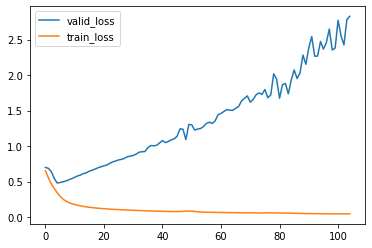

train_loss: 0.37847 | train_metric: 0.92069
valid_loss: 0.48046 | valid_metric: 0.74552
test_loss:  0.46586 | test_auc:  0.75726
CPU times: user 43.1 s, sys: 288 ms, total: 43.4 s
Wall time: 44.4 s


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

ipnn = ProductBasedNeuralNetwork(field_dims, EMBEDDING_DIM, method='inner').to(device)
optimizer = optim.Adam(ipnn.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(ipnn, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))


 17%|█▋        | 103/600 [00:11<00:56,  8.76it/s]


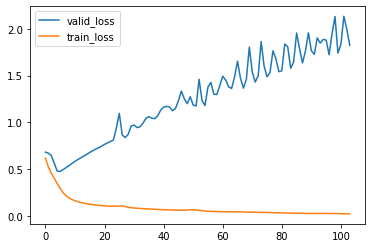

train_loss: 0.52820 | train_metric: 0.88899
valid_loss: 0.56167 | valid_metric: 0.75441
test_loss:  0.55713 | test_auc:  0.75918
CPU times: user 11.8 s, sys: 154 ms, total: 12 s
Wall time: 12 s


In [7]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

opnn = ProductBasedNeuralNetwork(field_dims, EMBEDDING_DIM, method='outer').to(device)
optimizer = optim.Adam(opnn.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(opnn, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
